In [9]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings('ignore')

## 1. Importing the preprocessed dataset

In [3]:
raw_data = pd.read_csv(r'..\..\Preprocessed_datasets\final_preprocessed_compas.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

### Investigating the number of errors & predictions in the dataset

In [4]:
# Number of errors
display(len(raw_data.loc[raw_data['errors']==1]))
display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

606

1246

### Utils

In [5]:
# new code 14-9
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)
    features = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
    if with_errors:
        scaling_factor = 0.8 
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_neg_bias = 999999
    print(fulldata['new_clusters'].unique())
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_neg_bias:
            max_neg_bias = current_bias
    print('discriminating bias is:', max_neg_bias)
    return max_neg_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(data.loc[data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size


In [4]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware DBSCAN Clustering 

In [10]:
full_data = initialize_dataset(raw_data)
full_data.head()

,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
4590,-0.672808,1.125535,-0.497974,1.899201,0.969158,-0.065866,-0.303284,-0.04028,-0.231235,-0.476763,1.331336,0.8,0,1,1,0,-1
2482,0.560285,1.125535,-0.497974,1.899201,-1.031824,-0.065866,-0.303284,-0.04028,-0.231235,-0.476763,-0.751125,0.8,1,0,1,0,-1
4092,-0.672808,-0.888466,2.008136,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,2.097479,-0.751125,0.8,0,1,1,0,-1
165,-0.672808,-0.888466,-0.497974,1.899201,0.969158,-0.065866,-0.303284,-0.04028,-0.231235,-0.476763,-0.751125,0.8,0,1,1,0,-1
1109,1.587862,1.125535,-0.497974,-0.526537,-1.031824,-0.065866,3.297240,-0.04028,-0.231235,-0.476763,1.331336,0.8,1,0,1,0,-1


## Determining the epsilon parameter using the K-Distance plot

Text(0.5, 1.0, 'Optimal Value of Epsilon for COMPAS')

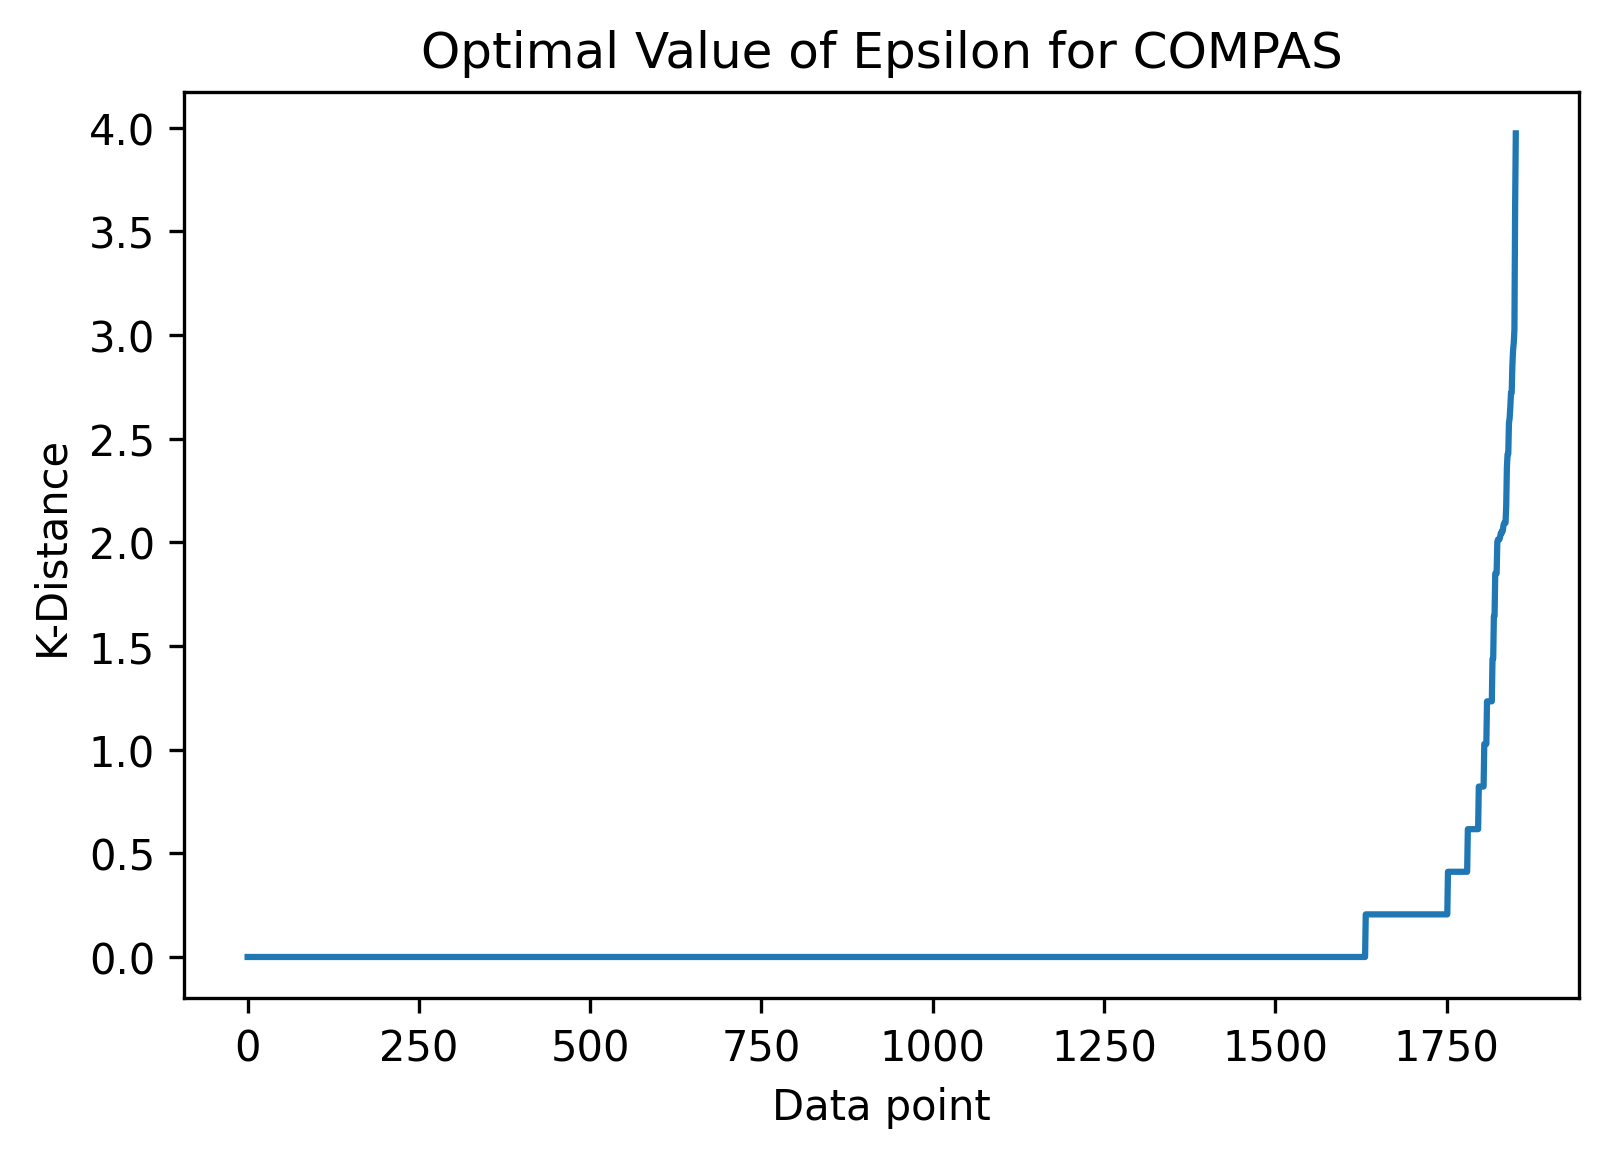

In [11]:
nn_features = full_data.iloc[: , : 11]

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Optimal Value of Epsilon for COMPAS')

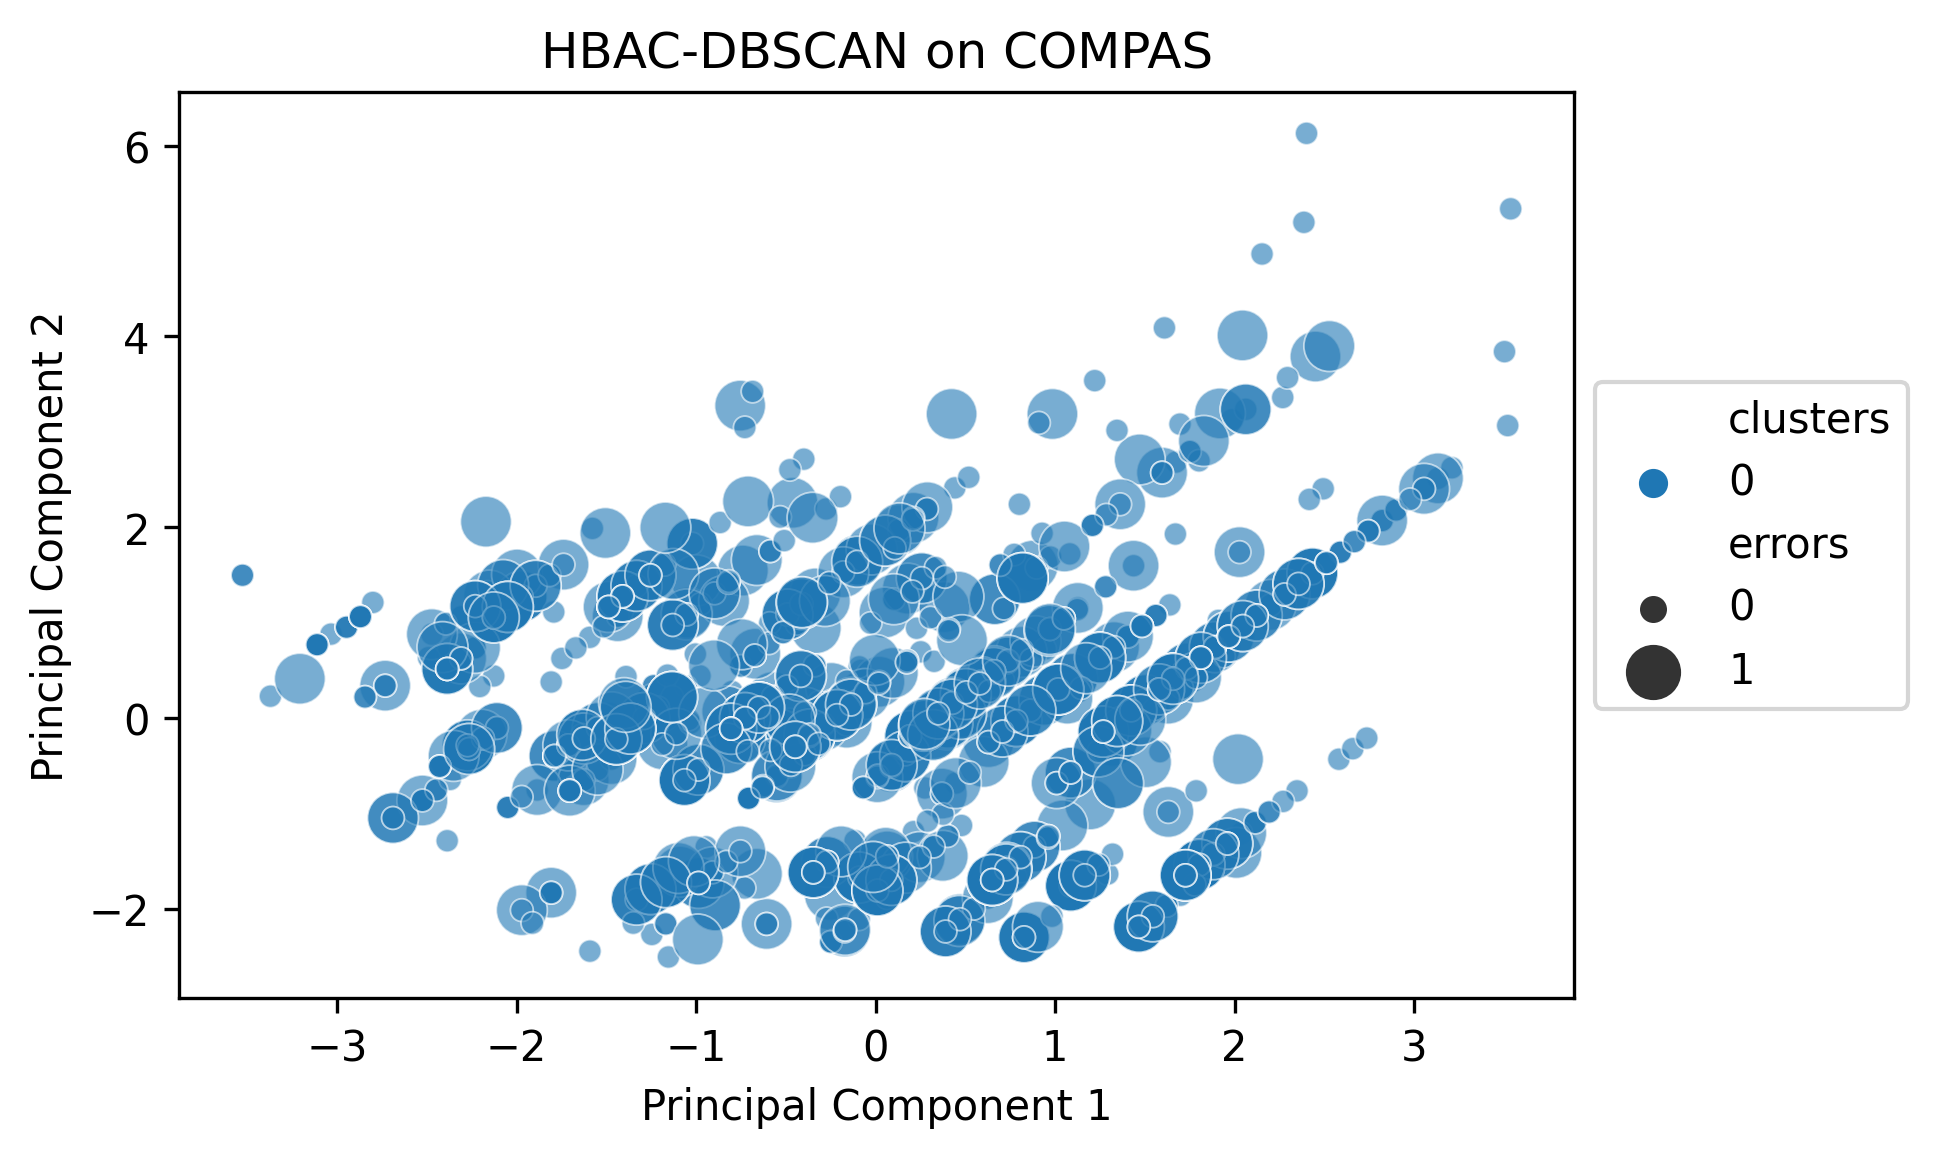

this is the current cluster:  0
[ 0  1 -1]
discriminating bias is: -0.02908544077463371
smallest cluster:  93


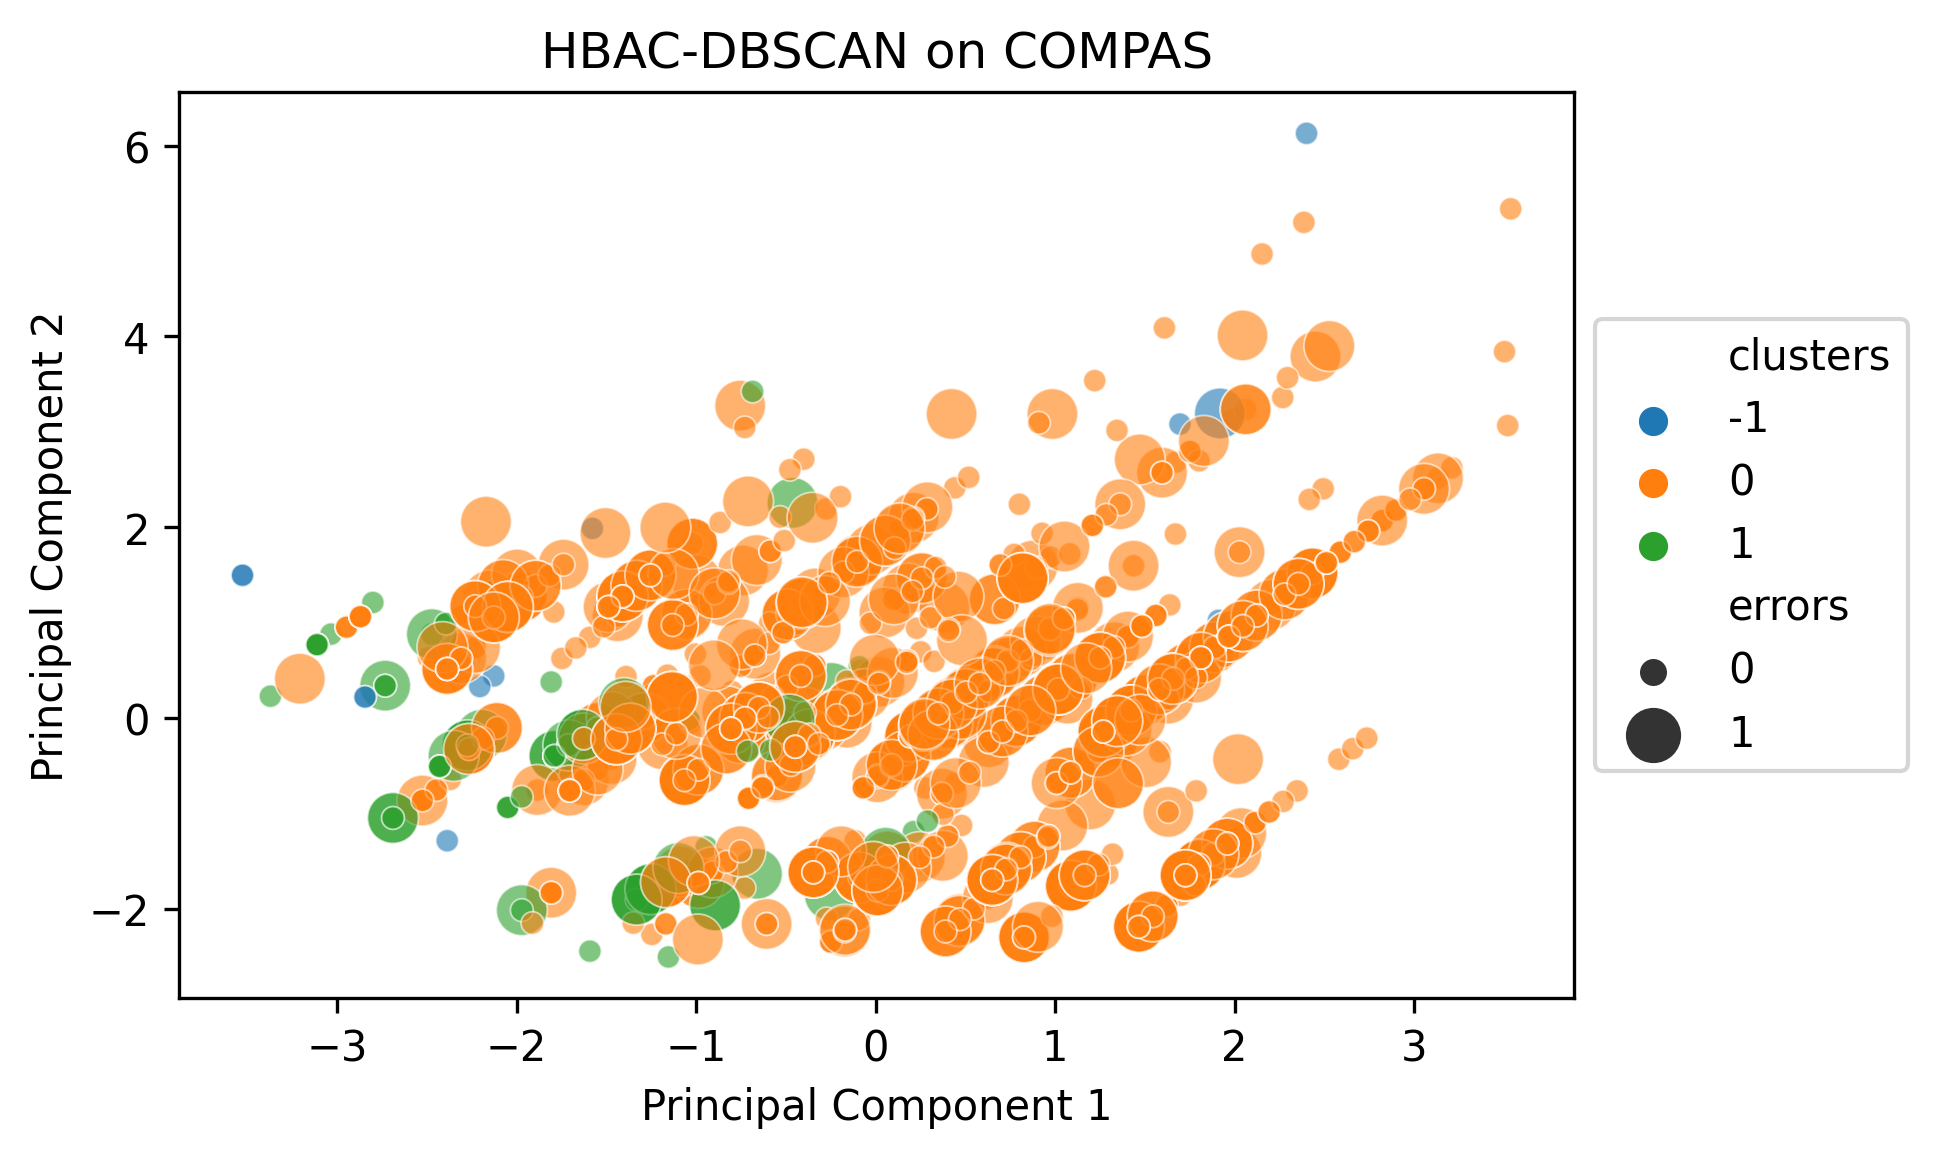

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
MAX_ITER
0.67278617710

In [12]:
MAX_ITER = 30
epsilon = 4
minimum_samples = 20 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-DBSCAN on COMPAS', 0.6)
variance_list = []
minimal_splittable_cluster_size = 5 #round(0.02 * len(full_data))
minimal_acceptable_cluster_size = 5 #round(0.02 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon + 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data, 'HBAC-DBSCAN on COMPAS', 0.6)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

# Analysing the biased cluster
## Goal 1: Identifying highest biased cluster

In [13]:
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"Cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

0 has bias -0.003608907787499671
1 has bias -0.02908544077463371
cluster with the highest discriminating bias: 1
General accuracy of classifier on this dataset: 0.6727861771058316
cluster 1 has the highest discrimination bias
-0.02908544077463371


## Further Analysis of the Biased Cluster
- Welch's statistical test
- Parallel Coordinate Plot

Number of instances in discriminated cluster: 93
Number of errors in discriminated clusters:  33
found discriminated cluster:


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
4092,-0.672808,-0.888466,2.008136,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,2.097479,-0.751125,0.8,0,1,1,1,0.0
4893,-0.672808,1.125535,-0.497974,1.899201,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,-0.751125,0.8,1,0,1,1,0.0
3195,-0.261777,-0.888466,-0.497974,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,1.331336,0.8,0,1,1,1,0.0
2745,0.149254,-0.888466,2.008136,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,-0.751125,0.0,0,0,0,1,0.0
3114,-0.467293,-0.888466,2.008136,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,1.331336,0.0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,-0.261777,-0.888466,-0.497974,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,-0.751125,0.8,0,1,1,1,0.0
4258,-0.261777,-0.888466,-0.497974,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,1.331336,0.0,0,0,0,1,0.0
6078,-0.672808,-0.888466,-0.497974,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,1.331336,0.0,0,0,0,1,0.0
4175,-0.672808,1.125535,-0.497974,-0.526537,-1.031824,-0.065866,-0.303284,-0.04028,4.324596,-0.476763,-0.751125,0.0,1,1,0,1,0.0


Number_of_Priors
this is the t-statistic -4.837668049333184
this is the p-value: 4.0502372617743695e-06
score_factor
this is the t-statistic -6.893309848261929
this is the p-value: 3.649261800382853e-10
Age_Above_FourtyFive
this is the t-statistic 0.13673193376281362
this is the p-value: 0.8915131381667059
Age_Below_TwentyFive
this is the t-statistic 0.20602410691552062
this is the p-value: 0.8371844735560796
African_American
this is the t-statistic -45.69651673586342
this is the p-value: 3.492903381331742e-301
Asian
this is the t-statistic -2.8340751092250054
this is the p-value: 0.004648350320935766
Hispanic
this is the t-statistic -13.079916555274762
this is the p-value: 2.2430197294984513e-37
Native_American
this is the t-statistic -1.7330368883817873
this is the p-value: 0.08326446674771751
Other
this is the t-statistic 1757.9999999999998
this is the p-value: 0.0
Female
this is the t-statistic -0.6381803874811913
this is the p-value: 0.5247712987467164
Misdemeanor
this is the t-st

,unscaled_discriminated,unscaled_remaining,difference
Number_of_Priors,1.666667,3.358727,-1.692060
score_factor,0.172043,0.455372,-0.283329
Age_Above_FourtyFive,0.204301,0.198408,0.005893
Age_Below_TwentyFive,0.225806,0.216600,0.009206
African_American,0.000000,0.542922,-0.542922
Asian,0.000000,0.004548,-0.004548
Hispanic,0.000000,0.088687,-0.088687
Native_American,0.000000,0.001706,-0.001706
Other,1.000000,0.000569,0.999431
Female,0.161290,0.186470,-0.025179


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors,index
unscaled_discriminated,1.666667,0.172043,0.204301,0.225806,0.000000,0.000000,0.000000,0.000000,1.000000,0.16129,0.387097,0.193548,0.376344,0.354839,unscaled_discriminated
unscaled_remaining,3.358727,0.455372,0.198408,0.216600,0.542922,0.004548,0.088687,0.001706,0.000569,0.18647,0.359295,0.425810,0.459352,0.325753,unscaled_remaining


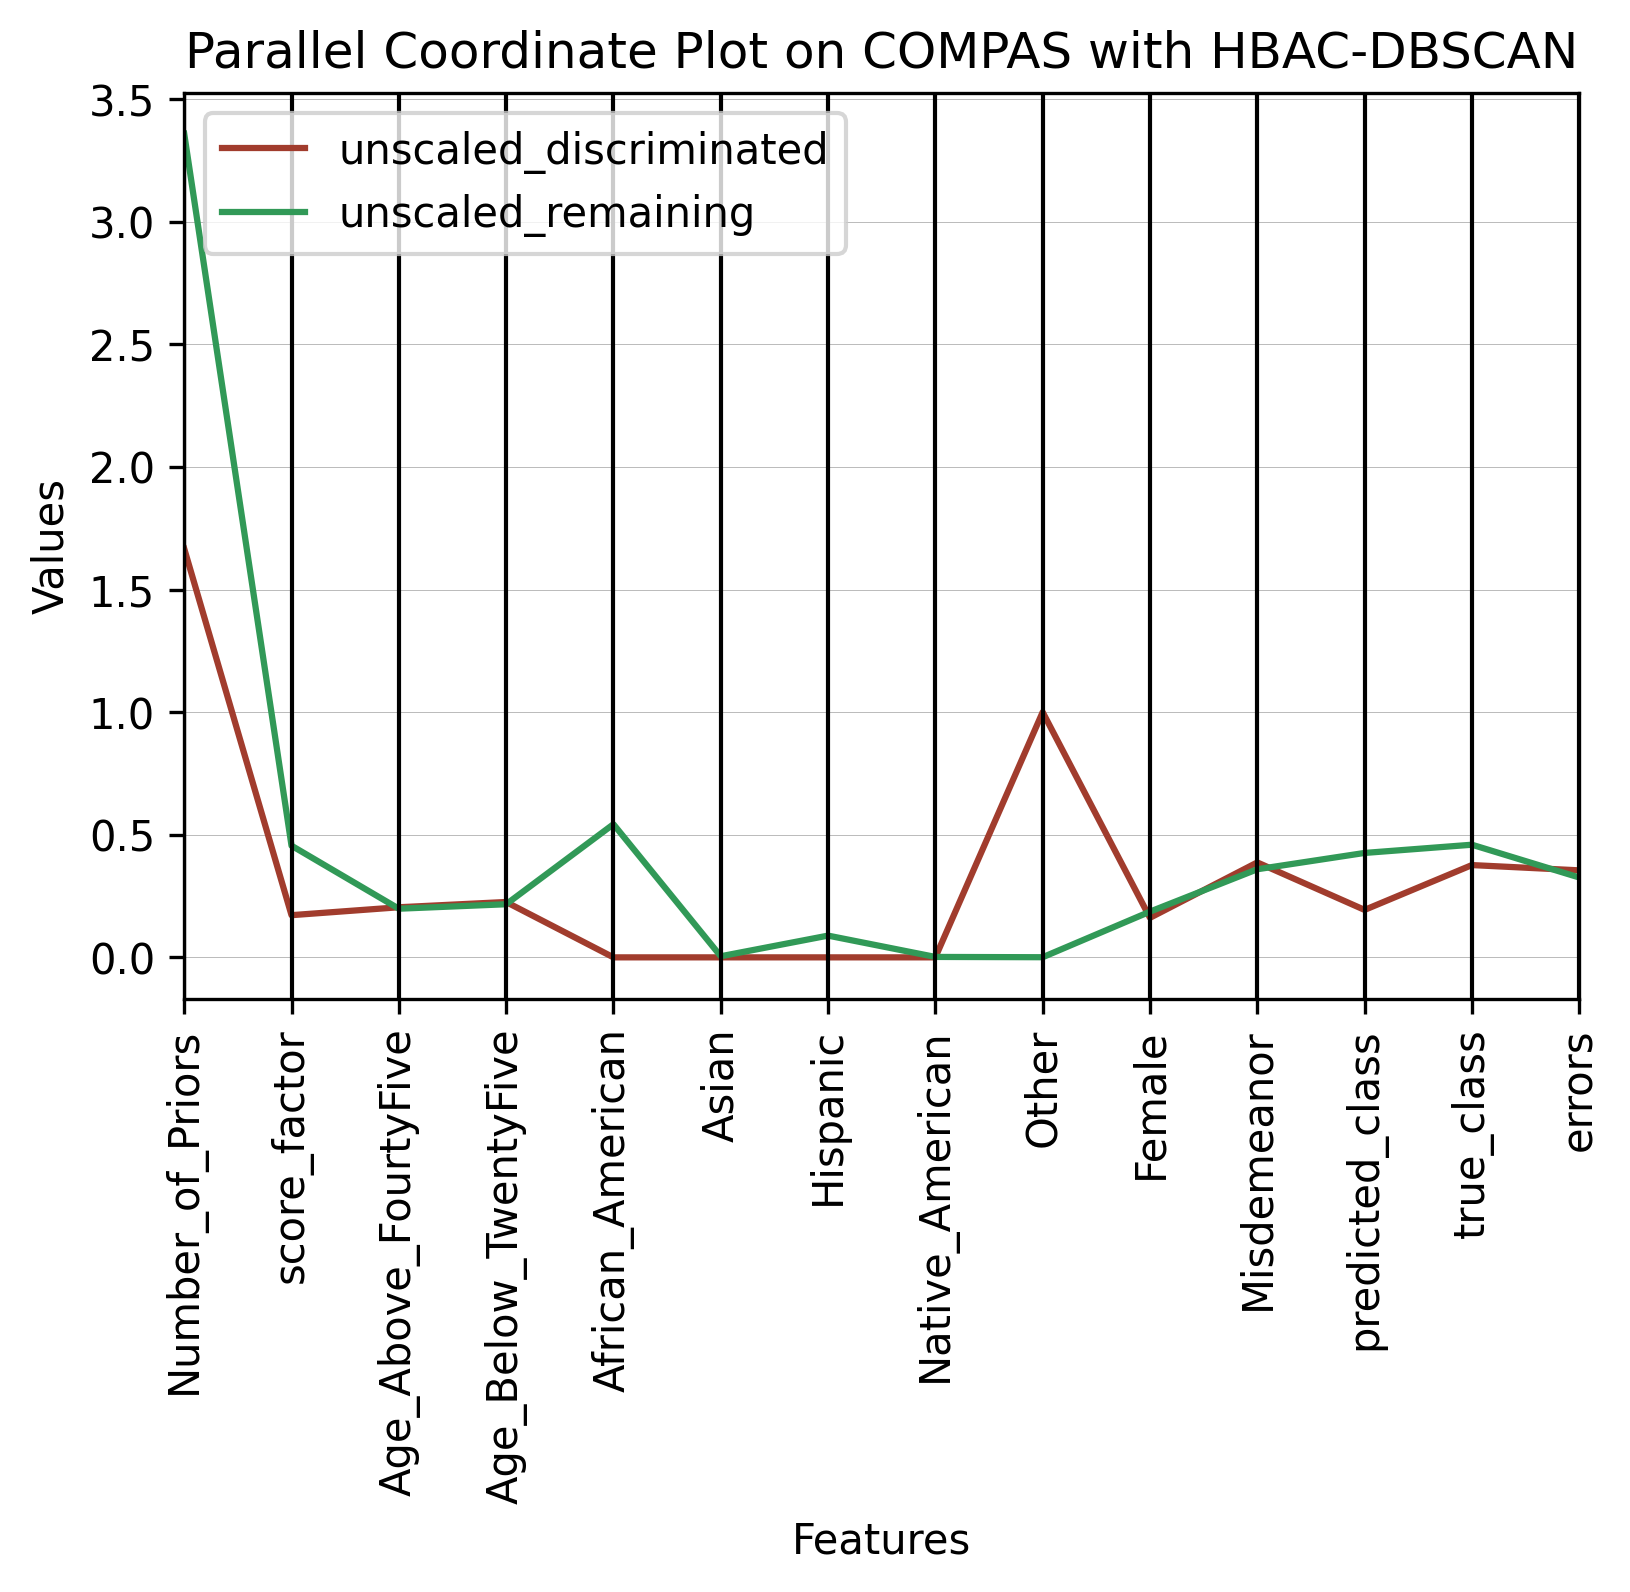

In [14]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-DBSCAN")

## Seaborn Density Plots

In [16]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']



,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors,bias
4092,0,0,1,0,0,0,0,0,1,1,0,0,1,1,discriminated
4893,0,1,0,1,0,0,0,0,1,0,0,1,0,1,discriminated
3195,2,0,0,0,0,0,0,0,1,0,1,0,1,1,discriminated
2745,4,0,1,0,0,0,0,0,1,0,0,0,0,0,discriminated
3114,1,0,1,0,0,0,0,0,1,0,1,0,0,0,discriminated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
4258,2,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
6078,0,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
4175,0,1,0,0,0,0,0,0,1,0,0,1,1,0,discriminated


In [32]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all[['African_American', 'Number_of_Priors', 'bias']]
welchtest = df_all

1


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

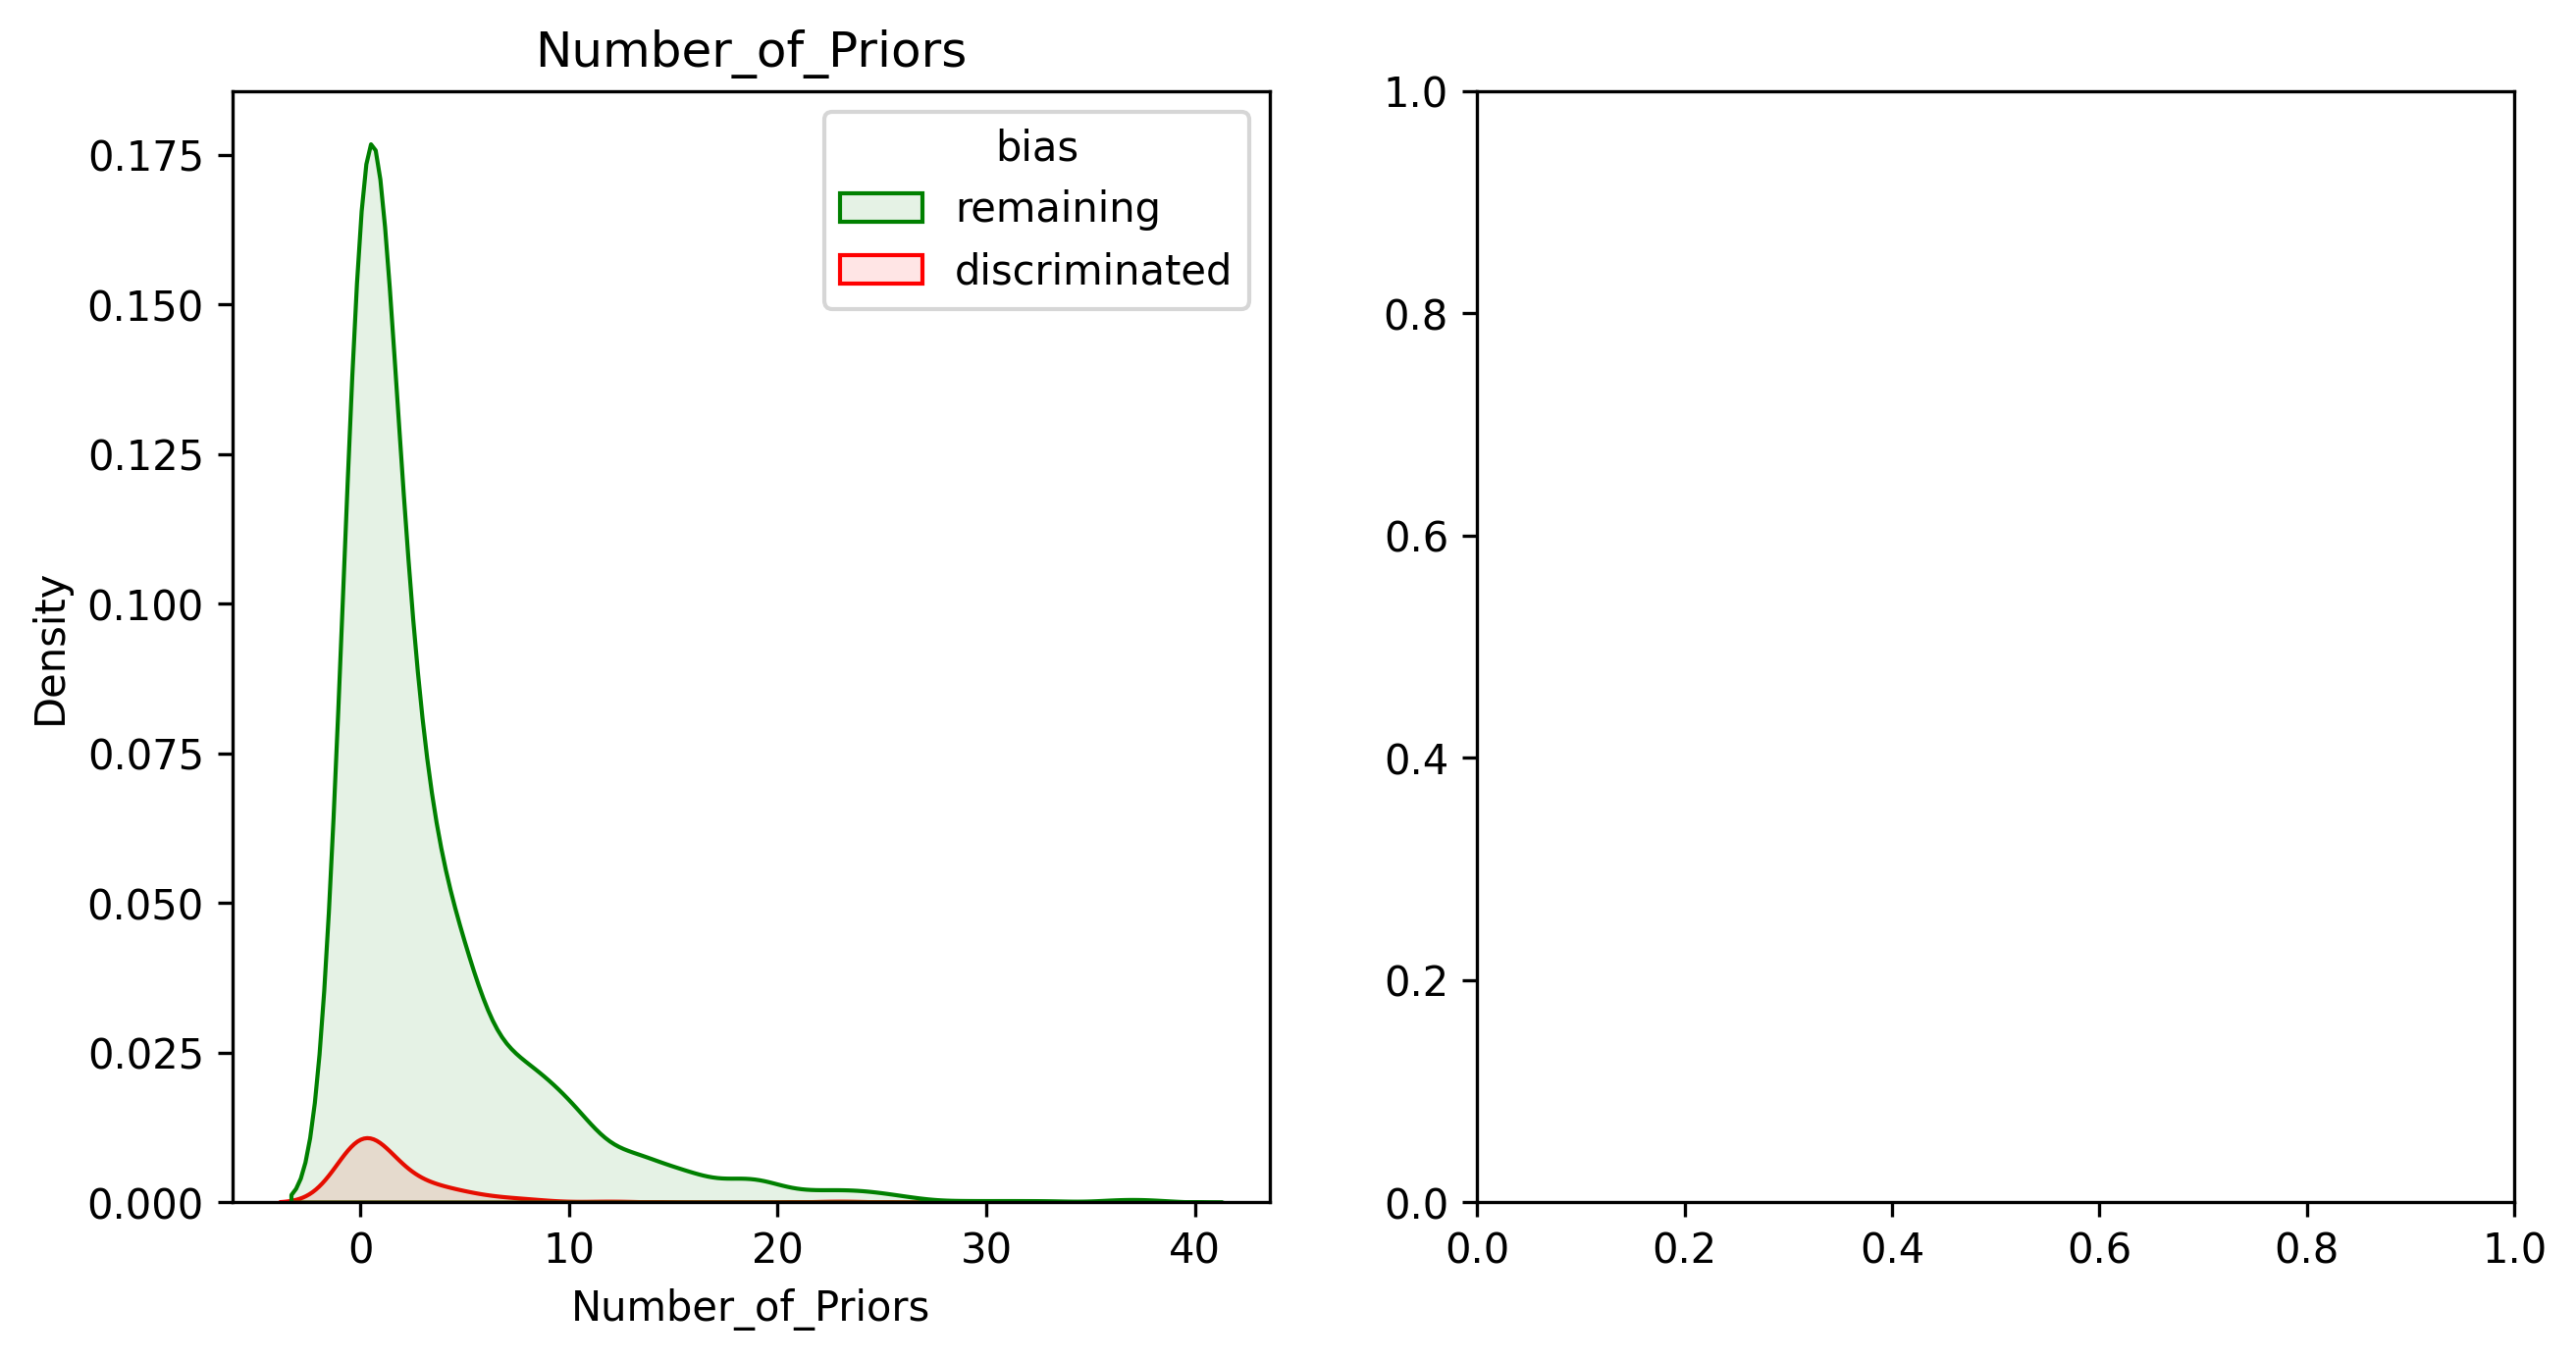

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()



NameError: name 'welchtest' is not defined

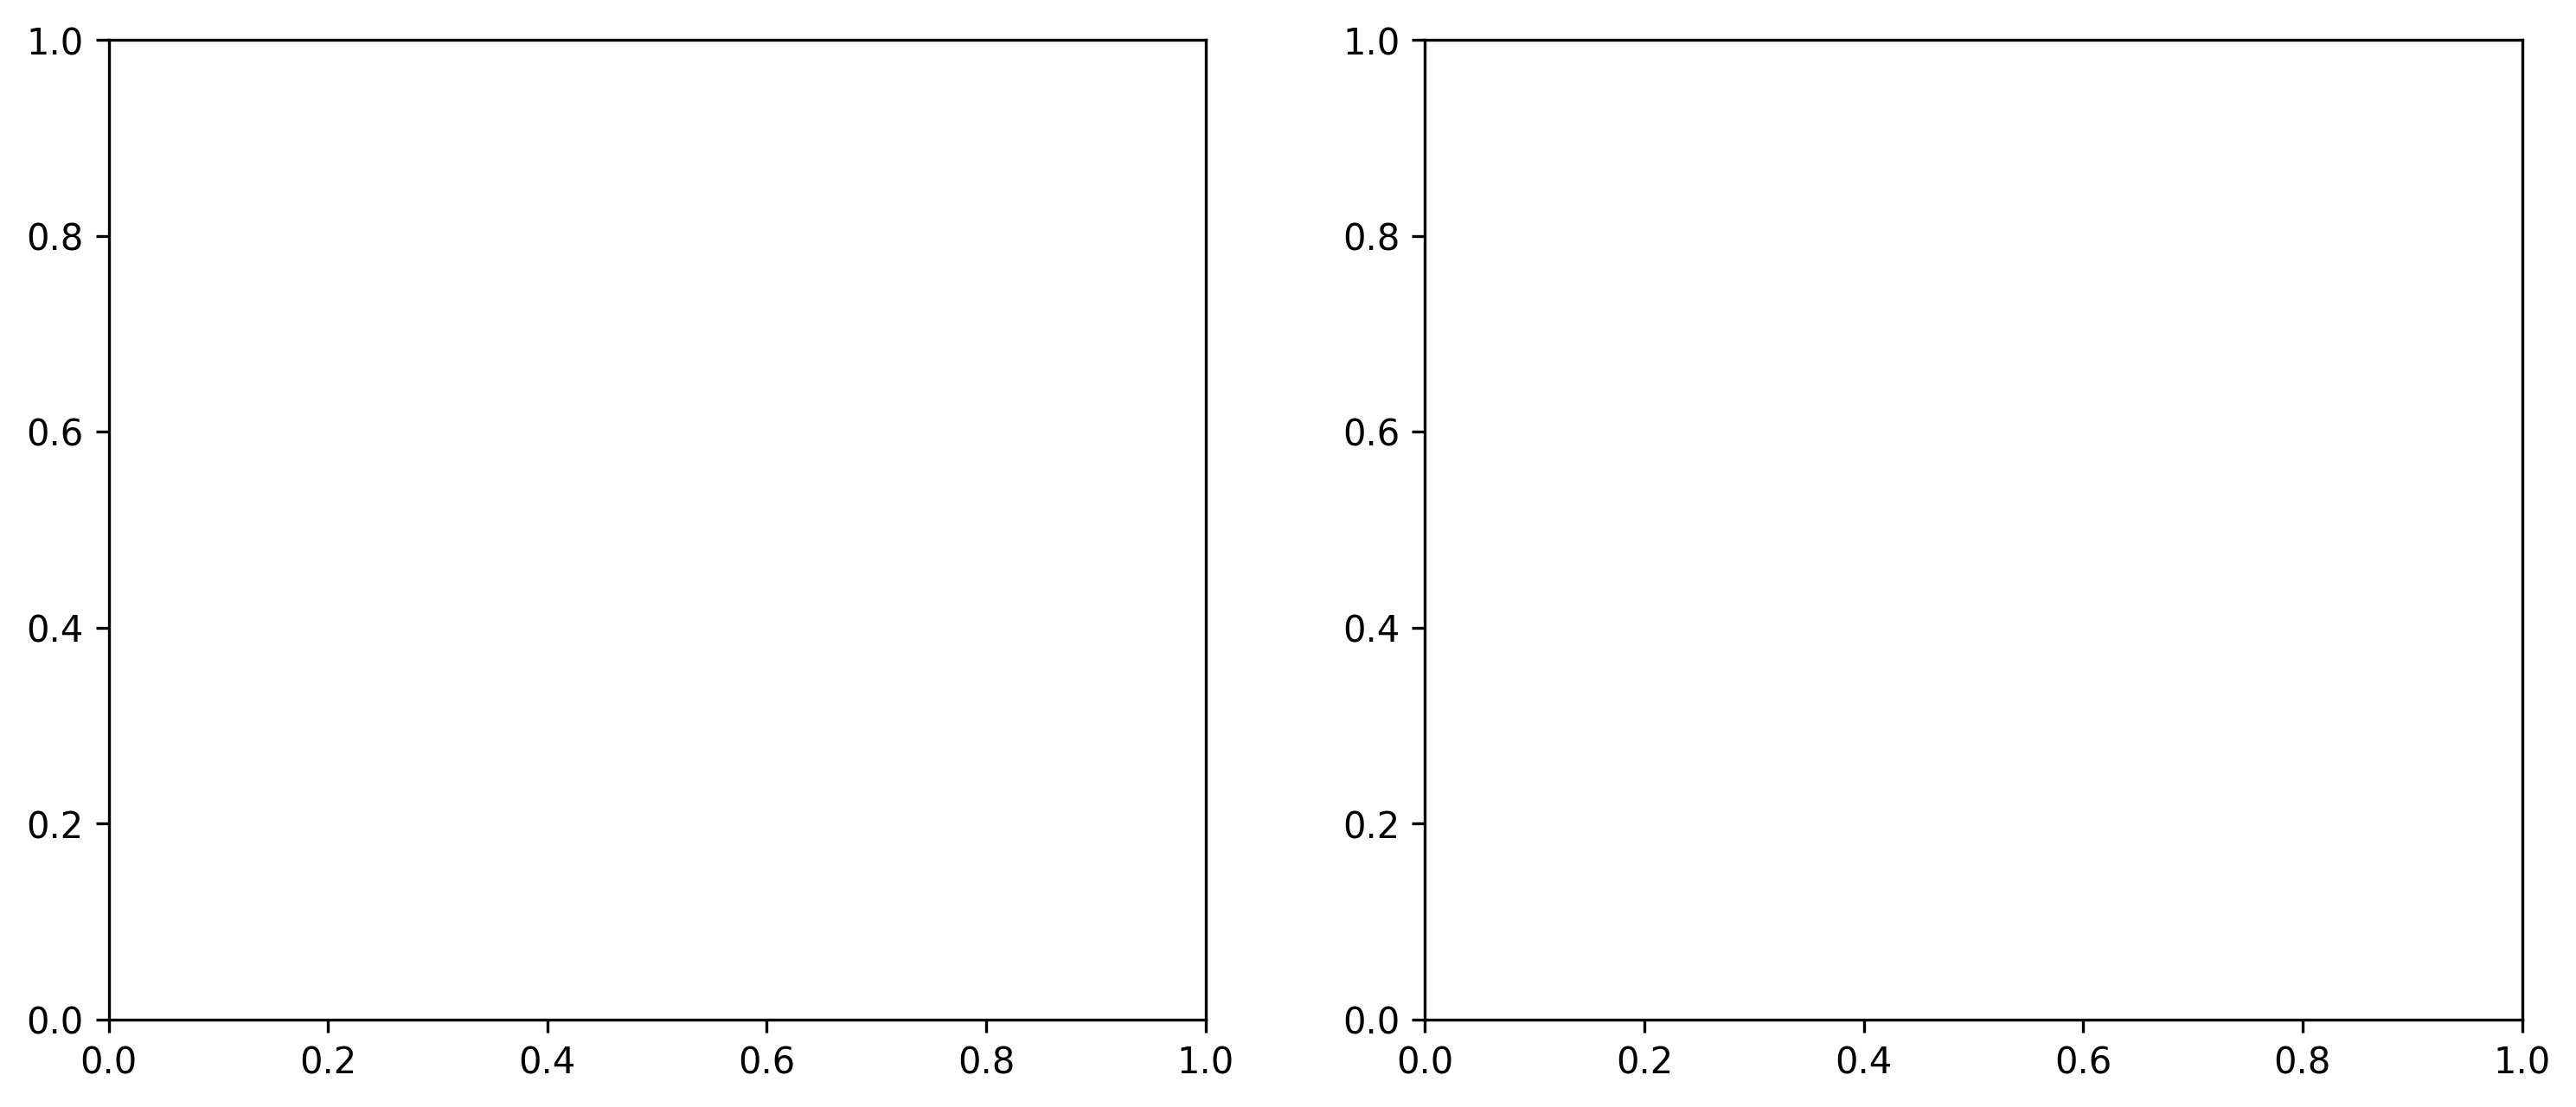

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()


## Plotly 

In [22]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors,bias
3195,2,0,0,0,0,0,0,0,1,0,1,0,1,1,discriminated
2252,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
3679,0,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
2524,1,0,0,1,0,0,0,0,1,0,0,0,1,1,discriminated
5140,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
4258,2,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
6078,0,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
4175,0,1,0,0,0,0,0,0,1,0,0,1,1,0,discriminated


## Seaborn Pairplot / Density plot

In [18]:
sns.pairplot(df_all, hue="bias")